# Alfworld Analysis Notebook

This part creates the basic import functions

eval "$(~/miniconda3/bin/conda shell.bash hook)"

eval "$(~/miniconda3/bin/conda shell.bash hook)"

## Import Statements

In [10]:
import os
import pandas as pd
# pd.set_option('max_colwidth', None)
# pd.set_option('display.precision', 4)


## Analysis Helper Functions
This is the new part of the analysis.

In [2]:
def get_data_file_path(current_trial_name="v1_eval", base_folder="game_logs", trial_base_name="alfworld_eval_", csv_file_name="alfworld_results.csv"):
    """returns the csv file path."""
    current_trial_folder = trial_base_name + current_trial_name
    file_path = os.path.join(base_folder, current_trial_folder, csv_file_name)
    return file_path

In [3]:
def convert_string_to_bool(in_string):
    """if string ="" False, else True"""
    if in_string:
        return True
    else:
        return False

def convert_string_to_bool_int(in_string):
    """if string ="" False, else True"""
    if in_string:
        return 1
    else:
        return 0

def convert_bool_string_to_bool_int(in_string):
    """ if string==False -> False, etc."""
    if in_string=="(False,)" or in_string=="False":
        return 0
    elif in_string=="(True,)" or in_string=="True":
        return 1
    elif in_string=="0":
        return 0
    elif in_string=="1":
        return 1
    else:
        print(type(in_string))
        print(in_string)
        print(in_string[0])
        raise Exception("Error in Transforming BoolString to Int")

In [4]:
def load_data(trial_name):
    file_path=os.path.join("game_logs",f"alfworld_eval_{trial_name}","alfworld_results.csv")
    df = pd.read_csv(
        file_path, 
        quoting=1,
        index_col=False, 
        converters = {
            "early_stop":convert_string_to_bool_int, 
            "error": convert_string_to_bool_int
        }
    )
    return df

In [5]:
import numpy as np
import pandas as pd

def analyse_data(input_data, total_envs: int = 134):
    """
    Returns:
        x     – DataFrame grouped by prompt_name **with a new 'failures' column**
        out2  – Flat table incl. success/fail + efficiency features:
                tokens_per_step, avg_history_token, efficiency_success_per_1k_tok
        success_df – Per-model per-task success table
    """
    # ------------------------------------------------------------------ #
    # Aggregate per model / prompt / correction (explicit agg to keep needed sums)
    # ------------------------------------------------------------------ #
    agg = (
        input_data
        .groupby(["model", "prompt_name", "correction"], as_index=False)
        .agg(
            success=("success", "sum"),
            total=("success", "count"),
            done=("done", "sum"),
            early_stop=("early_stop", "count"),  # placeholder; you can refine if needed
            error=("error", "count"),            # placeholder; you can refine if needed
            num_of_steps=("num_of_steps", "sum"),

            # token sums across episode runs
            total_prompt_token=("total_prompt_token", "sum"),
            total_in_token_accumulated=("total_in_token_accumulated", "sum"),
            total_in_token_message_accumulated=("total_in_token_message_accumulated", "sum"),
            total_out_token_accumulated=("total_out_token_accumulated", "sum"),
            total_history_token=("total_history_token", "sum"),
        )
    )

    # Compute failures and success %
    agg["failures"] = agg["total"] - agg["success"]
    agg["success_percentage"] = agg["success"] / total_envs * 100.0

    # Efficiency-related totals
    agg["total_io_tokens"] = (
        agg["total_in_token_accumulated"] + agg["total_out_token_accumulated"]
    )

    # Tokens per step (guard against zero division)
    agg["tokens_per_step"] = agg["total_io_tokens"] / agg["num_of_steps"].replace(0, np.nan)

    # Average history length at the end of an episode (mean across runs)
    agg["avg_history_token"] = agg["total_history_token"] / agg["total"].replace(0, np.nan)

    # Efficiency metric: successes per 1k total tokens
    # (how many successful episodes you got per 1,000 tokens spent)
    denom_k = (agg["total_io_tokens"] / 10000).replace(0, np.nan)
    agg["efficiency_success_per_10k_tok"] = agg["success"] / denom_k
    
    agg["total_io_tokens"] = agg["total_io_tokens"] / agg["total"]

    # ------------------------------------------------------------------ #
    # Average steps (overall / conditioned on success or failure) by model
    # ------------------------------------------------------------------ #
    avg_suc_steps, avg_fail_steps, avg_steps = [], [], []
    success_table = []

    for model in input_data.model.unique():
        model_data = input_data[input_data["model"] == model]

        avg_suc_steps.append(model_data[model_data["success"] == True]["num_of_steps"].mean())
        avg_fail_steps.append(model_data[model_data["success"] == False]["num_of_steps"].mean())
        avg_steps.append(model_data["num_of_steps"].mean())

        # Per-task success table for this model
        for task in sorted(model_data["env_type"].unique()):
            sub = model_data[model_data["env_type"] == task]
            total = len(sub)
            success = (sub["success"].sum() / total * 100) if total else 0.0
            success_table.append({
                "Model": model,
                "Task": task.capitalize(),
                "Success": f"{success:.2f}%",
            })

    success_df = pd.DataFrame(success_table)

    # Attach avg step stats once per-agg row by aligning on model
    model_stats = (
        pd.DataFrame({
            "model": input_data.model.unique(),
            "avg_success_steps": avg_suc_steps,
            "avg_fail_steps": avg_fail_steps,
            "avg_steps": avg_steps,
        })
    )
    agg = agg.merge(model_stats, on="model", how="left")

    # ------------------------------------------------------------------ #
    # Prepare `out` (keeps your legacy columns) and `x`
    # ------------------------------------------------------------------ #
    out_header_order = [
        "model", "prompt_name", "correction",
        # legacy metrics
        "success", "failures", "done", "num_of_steps",
        # percentages / averages you were already returning
        "success_percentage", "avg_success_steps", "avg_fail_steps", "avg_steps",
        # new efficiency-related columns
        "total_io_tokens", "tokens_per_step", "avg_history_token", "efficiency_success_per_10k_tok",
    ]
    # Some legacy columns (env_idx, early_stop, error) were sums/counts above; include if you want:
    # out_header_order.extend(["early_stop", "error"])

    out = agg[out_header_order].copy()

    # Group object (by prompt_name) like before
    x = out.groupby("prompt_name")

    # Flat summary table (your former out2), now with the new metrics
    out2 = out[[
        "model", "prompt_name", "correction",
        "success_percentage", "success", "failures",
        "avg_success_steps", "avg_fail_steps", "avg_steps",
        "total_io_tokens", "tokens_per_step", "avg_history_token", "efficiency_success_per_10k_tok",
    ]].copy()

    return x, out2, success_df

In [6]:
def print_results(file_name):
    df = load_data(file_name)

    print(df.agent_type.unique())
    print(df.model.unique())
    print(f"\nResults for {file_name}")
    success_table = {}
    for model in df.model.unique():
        success_table[model] = []
        print(f"For Model: {model}")
        df_m = df[df.model == model]
        for agent in df.agent_type.unique():
            print(f"\nFor Agent: {agent}")
            df_t = df_m[df_m.agent_type == agent]
            print(f"Success: {df_t.success.mean()*100:.2f}")
            print(f"Avg. Steps: {df_t.num_of_steps.mean():.2f}")
            print(f"Avg. Tokens: {df_t.total_in_token_accumulated.mean() + df_t.total_out_token_accumulated.mean():.0f}")
            
            # Per-task success table for this model
            for task in sorted(df_t["env_type"].unique()):
                sub = df_t[df_t["env_type"] == task]
                total = len(sub)
                success = (sub["success"].sum() / total * 100) if total else 0.0
                success_table[model].append({
                    "Agent": agent,
                    "Task": task.capitalize(),
                    "Success": f"{success:.2f}%",
                })
            print(f"Successes: {len(df_t[df_t.success==1])}, Fails: {len(df_t[df_t.success==0])}")
    
        print(pd.DataFrame(success_table[model]))

## Analysis

In [13]:
# file_name = "state_rag_selfgenerated_tagged" #83.58
# file_name = "react_rag_selfgenerated_tagged" #86.57
# file_name = "state_rag_selfgenerated_ft_state_tagged" #83.58
# file_name = "react_rag_selfgenerated_ft_react_tagged" #88.81


# file_name = "state_rag_selfgenerated" #85.07 #Beat 24 fails
# file_name = "react_rag_selfgenerated" #88.81 #Beat 30/29 fails
# file_name = "react_rag_selfgenerated_reacthints" #79.10

# file_name = "state_rag_selfgenerated_ft_state" #79.85
# file_name = "react_rag_selfgenerated_ft_react" #82.84

# file_name = "state_rag_selfgenerated_train" #84.17
# file_name = "react_rag_selfgenerated_train" #74.58

# file_name = "baseline_state_train_all_logged" #73.00
# file_name = "baseline_react_train_all" #61.17
# file_name = "react_rag_selfgenerated_train_reacthints" #79.83

# file_name = "react_rag_selfgenerated_train"
# file_name = "state_rag_selfgenerated_train"

print_results(file_name)

new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
# print(df.to_markdown(index=False))
y

['react']
['Qwen/Qwen2.5-14B-Instruct']

Results for react_rag_selfgenerated_train
For Model: Qwen/Qwen2.5-14B-Instruct

For Agent: react
Success: 74.58
Avg. Steps: 22.76
Avg. Tokens: 1543114
Successes: 895, Fails: 305
   Agent     Task Success
0  react    Clean  66.94%
1  react     Cool  85.53%
2  react  Examine  88.46%
3  react     Heat  57.89%
4  react      Put  92.64%
5  react   Puttwo  62.37%


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,667.910448,895,305,20.256983,30.118033,22.763333,1.543114e+06,67789.471409,2390.7175,0.004833


In [15]:
# file_name = "state_selfgenerated_ft_state_rag" #89.55, 13.99, 52k
# file_name = "react_selfgenerated_ft_react_rag" #92.54, 19.37, 38k 
# file_name = "state_rag_selfgenerated_ft_state_rag" #90.30, 13.82, 51k
file_name = "react_rag_selfgenerated_ft_react_rag" #93.28, 18.75, 39k


print_results(file_name)

new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
# print(df.to_markdown(index=False))
y

['react']
['Qwen/Qwen2.5-14B-Instruct']

Results for react_rag_selfgenerated_ft_react_rag
For Model: Qwen/Qwen2.5-14B-Instruct

For Agent: react
Success: 93.28
Avg. Steps: 18.75
Avg. Tokens: 38990
Successes: 125, Fails: 9
   Agent     Task  Success
0  react    Clean  100.00%
1  react     Cool   95.24%
2  react  Examine   88.89%
3  react     Heat   91.30%
4  react      Put  100.00%
5  react   Puttwo   76.47%


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,93.283582,125,9,17.616,34.555556,18.753731,38990.179104,2079.062475,2293.059701,0.239249


In [112]:
# file_name = "baseline_state_train_all" #73.17
# file_name = "baseline_state_gpt4o_train_all" #80.5
# file_name = "baseline_expel_train_all" #72.67

# file_name = "baseline_state_prompt_dividers" #82.96

# file_name = "hints_diffprompt" #75.56
# file_name = "hints_gold_fix" #75.56
# file_name = "hints_gold_ontop" #79.26

file_name = "hints_gold_gpt4o" #85.82, 13.67

# file_name = "stateact_ft_gold_1epoch_nofewshot_nobadsteps_lowlr_fixed" #82.96
# file_name = "hints_ft_gold_1epoch_nofewshot_nobadsteps_lowlr" #85.93

# file_name = "react_hints_ft_gold_1epoch_nofewshot_nobadsteps_lowlr" #90.37
# file_name = "react_ft_gold_1epoch_nofewshot_nobadsteps_lowlr" # 87.41


file_name = "react_vanilla_ft_vanilla_all" #72.39

# file_name = "state_hints_ft_vanilla_handpicked" #87.41
# file_name = "react_hints_ft_vanilla_all" #89.63??????

new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
print(df.to_markdown(index=False))
y

| Model                     | Task    | Success   |
|:--------------------------|:--------|:----------|
| Qwen/Qwen2.5-14B-Instruct | Clean   | 80.65%    |
| Qwen/Qwen2.5-14B-Instruct | Cool    | 100.00%   |
| Qwen/Qwen2.5-14B-Instruct | Examine | 50.00%    |
| Qwen/Qwen2.5-14B-Instruct | Heat    | 69.57%    |
| Qwen/Qwen2.5-14B-Instruct | Put     | 75.00%    |
| Qwen/Qwen2.5-14B-Instruct | Puttwo  | 47.06%    |


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,72.38806,97,37,18.329897,23.567568,19.776119,40931.955224,2069.766792,2291.477612,0.17685


In [58]:

# file_name = "state_hints_ft_rag_20handpicked_lorareg" #93.28
file_name = "state_vanilla_ft_rag_20handpicked_lorareg" #90.30

# file_name = "state_hints_ft_rag_all_lorareg" #90.30
# file_name = "state_vanilla_ft_rag_all_lorareg" #85.07


new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
print(df.to_markdown(index=False))
y

| Model     | Task    | Success   |
|:----------|:--------|:----------|
| ours-text | Clean   | 93.55%    |
| ours-text | Cool    | 95.24%    |
| ours-text | Examine | 83.33%    |
| ours-text | Heat    | 100.00%   |
| ours-text | Put     | 100.00%   |
| ours-text | Puttwo  | 58.82%    |


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,90.298507,121,13,NaN,NaN,NaN,7159072,3703.606829,4105.641791,0.169016


In [18]:
# file_name = "stateact_ft_react" #71.64
file_name = "react_ft_react" #86.57

# file_name = "stateact_rag_ft_react" #
# file_name = "react_rag_ft_react" #82.09


# new_eval = load_data(file_name)
new_eval = pd.read_csv("game_logs_ftreact/alfworld_eval_"+file_name+"/alfworld_results.csv")
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
print(df.to_markdown(index=False))
y

| Model                     | Task    | Success   |
|:--------------------------|:--------|:----------|
| Qwen/Qwen2.5-14B-Instruct | Clean   | 90.32%    |
| Qwen/Qwen2.5-14B-Instruct | Cool    | 76.19%    |
| Qwen/Qwen2.5-14B-Instruct | Examine | 94.44%    |
| Qwen/Qwen2.5-14B-Instruct | Heat    | 86.96%    |
| Qwen/Qwen2.5-14B-Instruct | Put     | 95.83%    |
| Qwen/Qwen2.5-14B-Instruct | Puttwo  | 70.59%    |


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,86.567164,116,18,23.172414,39.666667,25.38806,54983.335821,2165.716343,2472.91791,0.157443


In [37]:
#7B LAND

# file_name = "baseline_7B" #42.54 state, DO NOT USE
# file_name = "baseline_7B_rag" #63.43 react, 65.67 state
# file_name = "7B_react_rag_self" #73.13
file_name = "7B_state_rag_self" #69.40

# file_name = "7B_react_vanilla_ft_vanilla_all" #11.19
# file_name = "7B_react_vanilla_ft_vanilla_20handpicked" #49.25

# file_name = "7B_state_vanilla_ft_vanilla_all" #75.37
# file_name = "7B_state_vanilla_ft_vanilla_20handpicked" #62.69

# file_name = "7B_react_vanilla_ft_rag_all" #33.58
file_name = "7B_react_vanilla_ft_rag_all_self" #68.66
# file_name = "7B_react_vanilla_ft_rag_20handpicked" #53.73

# file_name = "7B_react_rag_ft_vanilla_all" #40.30
file_name = "7B_react_rag_ft_vanilla_all_self" #42.54
# file_name = "7B_react_rag_ft_vanilla_20handpicked" #61.94

# file_name = "7B_state_rag_ft_vanilla_all" #81.34
file_name = "7B_state_rag_ft_vanilla_all_self" #84.33
# file_name = "7B_state_rag_ft_vanilla_20handpicked" #76.12

# file_name = "7B_state_vanilla_ft_rag_all" #82.09
file_name = "7B_state_vanilla_ft_rag_all_self" #
# file_name = "7B_state_vanilla_ft_rag_20handpicked" #60.45

# file_name = "7B_react_rag_ft_rag_all" #58.21
# file_name = "7B_react_rag_ft_rag_20handpicked" #71.64

# file_name = "7B_state_rag_ft_rag_all" #88.06
# file_name = "7B_state_rag_ft_rag_20handpicked" #74.63

print_results(file_name)

new_eval = load_data(file_name)
# new_eval.head()

x,y, df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')


# print(df.to_markdown(index=False))
# x.head(15)
y

['ours-text']
['Qwen/Qwen2.5-7B-Instruct']

Results for 7B_state_vanilla_ft_rag_all_self
For Model: Qwen/Qwen2.5-7B-Instruct

For Agent: ours-text
Success: 79.01
Avg. Steps: 15.30
Avg. Tokens: 51995
Successes: 64, Fails: 17
       Agent     Task  Success
0  ours-text    Clean   76.19%
1  ours-text     Cool   83.33%
2  ours-text  Examine   62.50%
3  ours-text     Heat   85.71%
4  ours-text      Put  100.00%
5  ours-text   Puttwo   44.44%


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-7B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,47.761194,64,17,11.921875,28.0,15.296296,51994.555556,3399.159806,3618.209877,0.151963


In [87]:
for prompt_name in new_eval.prompt_name.unique():
    a = new_eval[new_eval.prompt_name == prompt_name].num_of_steps.mean()
    print(prompt_name, a)

react-1_0 28.134328358208954
stringstate-1_0-k-goal+locations_visited+current_location+current_inventory+thought+action 18.402985074626866


In [175]:
# !/usr/bin/env python
# aggregate_hints_by_type.py
import argparse, json, pathlib, re
from collections import defaultdict, Counter


def title_type(t: str) -> str:
    return t.replace("-", " ").title()

def aggregate(in_path: str,
              top_k_triggers: int = 3,
              top_k_fixes: int = 3,
              max_env_types: int = 6):
    # type -> Counter(text -> count)
    counts = defaultdict(Counter)
    triggers = defaultdict(lambda: defaultdict(Counter))   # [type][text] -> Counter(trigger)
    fixes = defaultdict(lambda: defaultdict(Counter))      # [type][text] -> Counter(fix)
    envtypes = defaultdict(lambda: defaultdict(Counter))   # [type][text] -> Counter(env_type)
    # raise ValueError
                  
    n_lines = 0
    with open(in_path) as f:
        for line in f:
            n_lines += 1
            try:
                rec = json.loads(line)
            except Exception:
                continue

            env_type = str(rec.get("env_type","unknown"))
            # print(env_type)
            for h in rec.get("hints", []) or []:
                # t = normalize_type(h.get("type",""))
                t = env_type
                txt = (h.get("text") or "").strip()
                if not txt:
                    continue
                counts[t][txt] += 1
                # trig = (h.get("when_to_trigger") or "").strip()
                # fix  = (h.get("example_fix") or "").strip()
                # if trig:
                #     triggers[t][txt][trig] += 1
                # if fix:
                #     fixes[t][txt][fix] += 1
                if env_type:
                    envtypes[t][txt][env_type] += 1

    # Build output
    sections = {}
    types_sorted = [t for t in CANON_ORDER if t in counts] + sorted(
        [t for t in counts.keys() if t not in CANON_ORDER]
    )
    for t in types_sorted:
        items = []
        for text, c in counts[t].most_common():
            # top_trigs = [k for k,_ in triggers[t][text].most_common(top_k_triggers)]
            # top_fix   = [k for k,_ in fixes[t][text].most_common(top_k_fixes)]
            top_envs  = dict(envtypes[t][text].most_common(max_env_types))
            # items.append({
            #     "text": text,
            #     "count": c,
            #     # "top_triggers": top_trigs,
            #     # "top_example_fixes": top_fix,
            #     # "env_types": top_envs,
            # })
            items.append(text)
            
        sub_section = {}
        # sub_section[title_type(t)] = {}
        sub_section = {
            "total_unique_hints": len(items),
            "total_mentions": sum(counts[t].values()),
            "hints": items
        }
        sections[title_type(t).lower()] = {}
        sections[title_type(t).lower()] = sub_section
        # sections.append(sub_section)
        # sections.append({
        #     "type": title_type(t),
        #     "total_unique_hints": len(items),
        #     "total_mentions": sum(counts[t].values()),
        #     "hints": items
        # })
    return sections
    # return {
    #     # "summary": {
    #     #     "files_processed": 1,
    #     #     "lines_read": n_lines,
    #     #     "total_types": len(sections),
    #     #     "total_unique_hints": sum(len(s["hints"]) for s in sections),
    #     #     "total_mentions": sum(s["total_mentions"] for s in sections),
    #     # },
    #     "by_type": sections
    # }


inp = "/workspace/stateact-ft/alfworld_runs/game_logs/hints_GPT4o.ndjson"
out = "/workspace/stateact-ft/alfworld_runs/game_logs/hints_by_type_GPT4o.json"
report = aggregate(inp, 3, 3, 6)
pathlib.Path(out).parent.mkdir(parents=True, exist_ok=True)
with open(out, "w") as f:
    json.dump(report, f, indent=2)
print(f"[OK] wrote → {out}")



[OK] wrote → /workspace/stateact-ft/alfworld_runs/game_logs/hints_by_type_GPT4o.json


In [103]:
file_name = "baseline_state"

# new_eval = load_data("v4_0_0_eval")
new_eval = load_data(file_name)
# new_eval.head()

x,y = analyse_data_old(new_eval)
y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

x.head(15)

,model,prompt_name,correction,env_idx,success,done,early_stop,error,num_of_steps,success_percentage
0,Qwen/Qwen2.5-14B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,8911,110,111,23,0,1968,81.481481
1,Qwen/Qwen2.5-7B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,8911,60,64,70,0,2275,44.444444


In [53]:
from scipy.stats import pearsonr, spearmanr, ks_2samp
import pandas as pd

def compute_correlation_with_significance(df, col1, col2):
    df = df[[col1, col2]].dropna()
    pearson_corr, pearson_p = pearsonr(df[col1], df[col2])
    spearman_corr, spearman_p = spearmanr(df[col1], df[col2])
    return {
        "pearson_correlation": pearson_corr,
        "pearson_p_value": pearson_p,
        "spearman_correlation": spearman_corr,
        "spearman_p_value": spearman_p
    }

def compare_distributions_ks(comparison_df, col1, col2):
    df = comparison_df[[col1, col2]].dropna()
    ks_stat, p_value = ks_2samp(df[col1], df[col2])
    return {
        "ks_statistic": ks_stat,
        "p_value": p_value
    }

def analyze_success_overlap(file1: str, file2: str, name1="file1", name2="file2"):
    # Load files
    df1 = pd.read_json(file1) if file1.endswith(".json") else pd.read_csv(file1)
    df2 = pd.read_json(file2) if file2.endswith(".json") else pd.read_csv(file2)

    # Filter for consistent model
    df1 = df1[df1["model"] == "Qwen/Qwen2.5-14B-Instruct"]
    df2 = df2[df2["model"] == "Qwen/Qwen2.5-14B-Instruct"]

    # Select relevant columns
    df1 = df1[["env_idx", "success", "env_type"]].rename(columns={"success": f"{name1}_success"})
    df2 = df2[["env_idx", "success", "env_type"]].rename(columns={"success": f"{name2}_success"})

    # Merge
    merged = pd.merge(df1, df2, on="env_idx", how="inner")

    # Compute overlap categories
    result_types = []
    for _, row in merged.iterrows():
        a = row[f"{name1}_success"]
        b = row[f"{name2}_success"]
        if a and b:
            result = "Both Successful"
        elif not a and not b:
            result = "Both Failed"
        elif a and not b:
            result = f"Only {name1} Successful"
        else:
            result = f"Only {name2} Successful"
        result_types.append(result)

    merged["result_type"] = result_types

    # Overall result summary
    summary = merged["result_type"].value_counts().reset_index()
    summary.columns = ["Outcome", "Count"]

    # Per-task outcome distribution
    summary_by_category = {}
    for env_type in merged["env_type_x"].unique():
        temp = merged[merged["env_type_x"] == env_type]
        counts = temp["result_type"].value_counts().reset_index()
        counts.columns = ["Outcome", "Count"]
        summary_by_category[env_type] = counts

    # Per-task success rate table
    success_table = []
    for task in sorted(merged["env_type_x"].unique()):
        sub = merged[merged["env_type_x"] == task]
        total = len(sub)
        baseline_success = sub[f"{name1}_success"].sum() / total * 100
        hint_success     = sub[f"{name2}_success"].sum() / total * 100
        success_table.append({
            "Task": task.capitalize(),
            f"{name1} Success": f"{baseline_success:.2f}%",
            f"{name2} Success": f"{hint_success:.2f}%"
        })

    success_df = pd.DataFrame(success_table)

    return summary, merged, summary_by_category, success_df


In [78]:
trial_num = 4
a = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_sanity_check_fixed/alfworld_results.csv"
# b = f"/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_expel_trial{trial_num}_retrieve_llm/alfworld_results.csv"
# a = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetuned/alfworld_results.csv"
# b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetuned_2/alfworld_results.csv"
# b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetunedonhints/alfworld_results.csv"
# b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetuned_bigmodel/alfworld_results.csv"
b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_stateact_ft_full_hard_abovemean/alfworld_results.csv"



# df = analyse_data_compare(a, b)
# df = compare_success_per_env_idx(a, b, "baseline", "trial4")
# corr = compute_correlation_with_significance(df, "baseline", "trial4")
summary, merged, summary_by_category, task_success_df = analyze_success_overlap(a, b, "Baseline", f"Hard FT")
# summary, merged, summary_by_category, task_success_df = analyze_success_overlap(a, b, "FT", f"FT on FT traces")
# df.to_csv("a.csv")
print(summary.to_string(index=False), "\n")

print(task_success_df.to_string(index=False))

for key, value in summary_by_category.items():
    print()
    print("For task type:", key)
    print(value.to_string(index=False))
# print(summary_by_category)

                 Outcome  Count
         Both Successful     97
 Only Hard FT Successful     19
Only Baseline Successful     13
             Both Failed      5 

   Task Baseline Success Hard FT Success
  Clean           87.10%          96.77%
   Cool           95.24%          85.71%
Examine           72.22%          66.67%
   Heat           86.96%         100.00%
    Put           91.67%         100.00%
 Puttwo           47.06%          52.94%

For task type: clean
                 Outcome  Count
         Both Successful     26
 Only Hard FT Successful      4
Only Baseline Successful      1

For task type: cool
                 Outcome  Count
         Both Successful     17
Only Baseline Successful      3
 Only Hard FT Successful      1

For task type: examine
                 Outcome  Count
         Both Successful      9
Only Baseline Successful      4
 Only Hard FT Successful      3
             Both Failed      2

For task type: put
                Outcome  Count
        Both Succ

In [28]:
merged[merged["result_type"]=="Both Failed"]

,env_idx,baseline_success,env_type_x,trial4_success,env_type_y,result_type
24,24,False,puttwo,False,puttwo,Both Failed
41,41,False,puttwo,False,puttwo,Both Failed
48,48,False,examine,False,examine,Both Failed
61,61,False,puttwo,False,puttwo,Both Failed
70,70,False,examine,False,examine,Both Failed
98,98,False,examine,False,examine,Both Failed
99,99,False,clean,False,clean,Both Failed
116,116,False,puttwo,False,puttwo,Both Failed


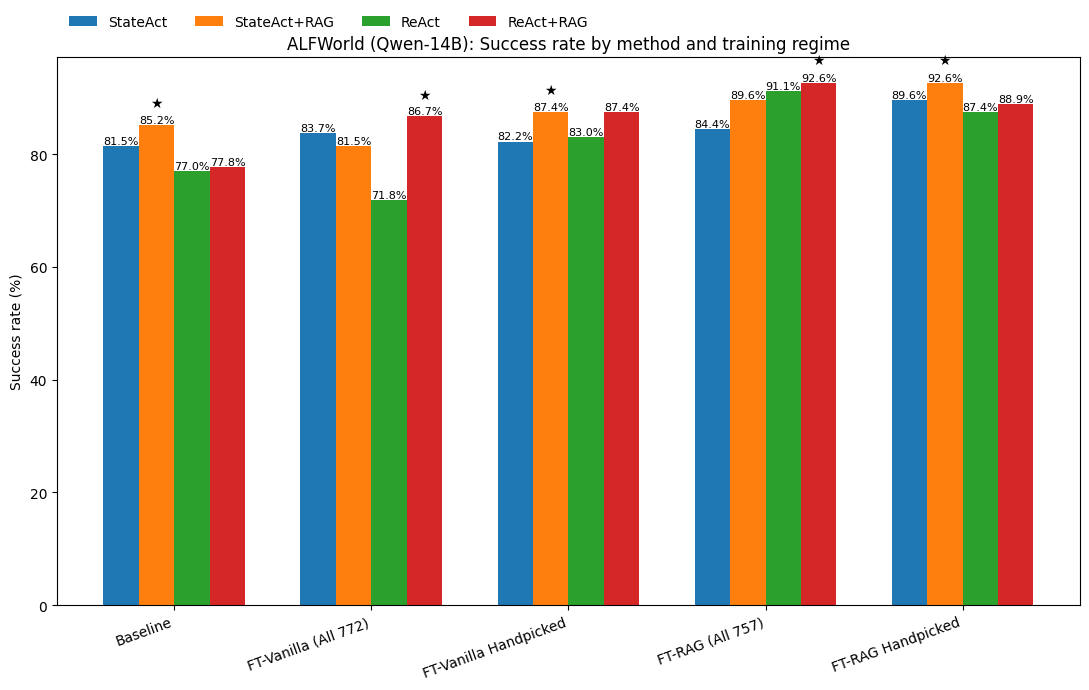

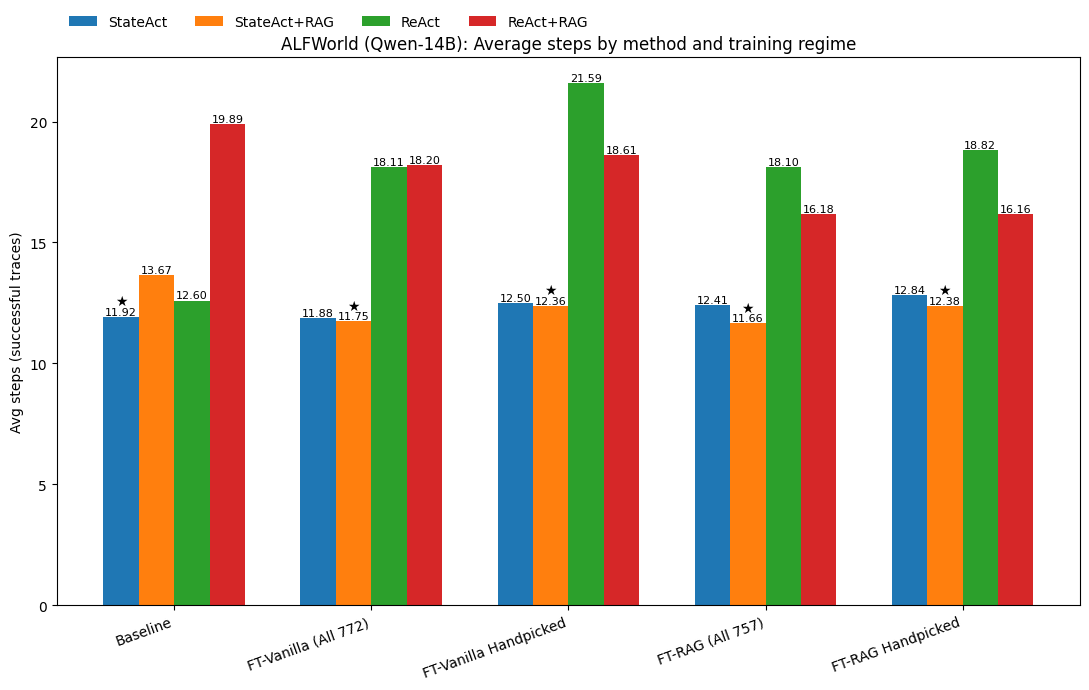

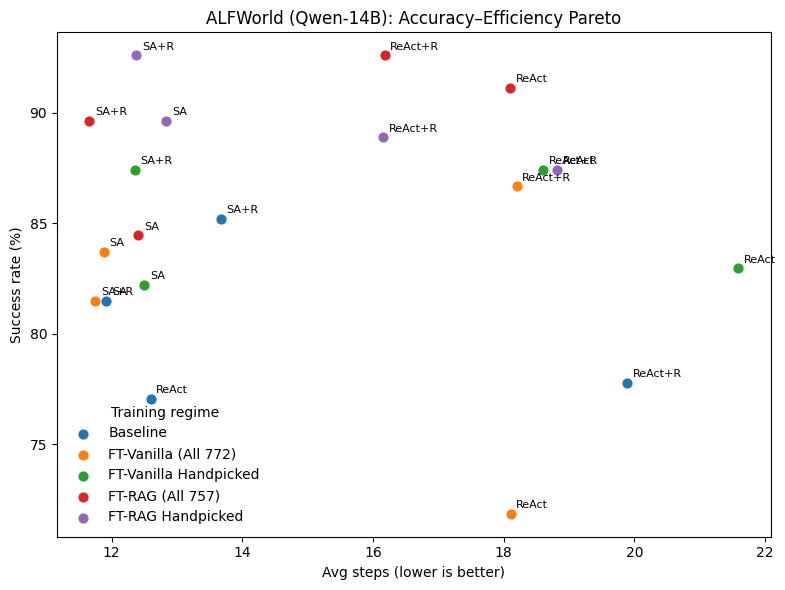

In [9]:
# Create tidy DataFrame and generate example plots (matplotlib only, no custom colors)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- Data ----------------------
methods = ["StateAct", "StateAct+RAG", "ReAct", "ReAct+RAG"]
regimes = [
    ("baseline",        0,   "Baseline"),
    ("ft_vanilla_all",  772, "FT-Vanilla (All 772)"),
    ("ft_vanilla_20",   120, "FT-Vanilla Handpicked"),
    ("ft_rag_all",      757, "FT-RAG (All 757)"),
    ("ft_rag_20",       120, "FT-RAG Handpicked"),
]

success = {
  "baseline":        [81.48, 85.19, 77.04, 77.78],
  "ft_vanilla_all":  [83.70, 81.48, 71.85, 86.67],
  "ft_vanilla_20":   [82.22, 87.41, 82.96, 87.41],
  "ft_rag_all":      [84.44, 89.63, 91.11, 92.59],
  "ft_rag_20":       [89.63, 92.59, 87.41, 88.89],
}
steps = {
  "baseline":        [11.92, 13.67, 12.60, 19.89],
  "ft_vanilla_all":  [11.88, 11.75, 18.11, 18.20],
  "ft_vanilla_20":   [12.50, 12.36, 21.59, 18.61],
  "ft_rag_all":      [12.41, 11.66, 18.10, 16.18],
  "ft_rag_20":       [12.84, 12.38, 18.82, 16.16],
}

rows = []
for key, n, label in regimes:
    for i, m in enumerate(methods):
        rows.append({
            "env": "ALFWorld",
            "backbone": "Qwen-14B",
            "method": m,
            "training_regime": key,
            "regime_label": label,
            "n_examples": n,
            "success_rate_pct": success[key][i],
            "avg_steps": steps[key][i],
        })
df = pd.DataFrame(rows)

# ---------------------- Helper: grouped bar plot ----------------------
def grouped_bar(df, value_col, ylabel, title, filename, annotate_pct=False, lower_is_better=False):
    x_labels = [r[2] for r in regimes]
    x = np.arange(len(x_labels))
    width = 0.18  # bar width
    fig = plt.figure(figsize=(11, 7))  # single-plot figure (no subplots)

    # compute best per regime for annotation
    best_indices = {}
    for i, (reg_key, _, _) in enumerate(regimes):
        sub = df[df["training_regime"] == reg_key]
        if lower_is_better:
            idx = sub[value_col].values.argmin()
        else:
            idx = sub[value_col].values.argmax()
        best_indices[reg_key] = idx  # index *within* order of methods

    # plot each method as its own series
    for j, method in enumerate(methods):
        vals = [df[(df["method"] == method) & (df["training_regime"] == rk)][value_col].values[0]
                for rk, _, _ in regimes]
        bars = plt.bar(x + (j-1.5)*width, vals, width, label=method)
        # annotate each bar
        for i_bar, b in enumerate(bars):
            v = b.get_height()
            if annotate_pct:
                label = f"{v:.1f}%"
            else:
                label = f"{v:.2f}"
            plt.text(b.get_x() + b.get_width()/2, v, label, ha='center', va='bottom', fontsize=8, rotation=0)
        # add asterisk to the best per regime
        for i_reg, (reg_key, _, _) in enumerate(regimes):
            if best_indices[reg_key] == j:
                bx = x[i_reg] + (j-1.5)*width
                bv = vals[i_reg]
                plt.text(bx, bv*1.03, "★", ha='center', va='bottom', fontsize=10)

    plt.xticks(x, x_labels, rotation=20, ha='right')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(0,1.1))
    plt.tight_layout()
    # plt.savefig(f"/mnt/data/{filename}", dpi=200)
    plt.show()

# ---------------------- Plot 1: Success rate ----------------------
grouped_bar(
    df=df,
    value_col="success_rate_pct",
    ylabel="Success rate (%)",
    title="ALFWorld (Qwen-14B): Success rate by method and training regime",
    filename="success_rates_grouped.png",
    annotate_pct=True,
    lower_is_better=False
)

# ---------------------- Plot 2: Avg steps ----------------------
grouped_bar(
    df=df,
    value_col="avg_steps",
    ylabel="Avg steps (successful traces)",
    title="ALFWorld (Qwen-14B): Average steps by method and training regime",
    filename="avg_steps_grouped.png",
    annotate_pct=False,
    lower_is_better=True
)

# ---------------------- Plot 3: Pareto (success vs steps) ----------------------
fig = plt.figure(figsize=(8, 6))
for (rk, n, label) in regimes:
    sub = df[df["training_regime"] == rk]
    x = sub["avg_steps"].values
    y = sub["success_rate_pct"].values
    plt.scatter(x, y, s=40, label=label)

# annotate short tags
tag_map = {"StateAct":"SA", "StateAct+RAG":"SA+R", "ReAct":"ReAct", "ReAct+RAG":"ReAct+R"}
for _, row in df.iterrows():
    tag = f'{tag_map[row["method"]]}'
    plt.annotate(tag, (row["avg_steps"], row["success_rate_pct"]), textcoords="offset points", xytext=(4,4), fontsize=8)

plt.xlabel("Avg steps (lower is better)")
plt.ylabel("Success rate (%)")
plt.title("ALFWorld (Qwen-14B): Accuracy–Efficiency Pareto")
plt.legend(frameon=False, title="Training regime")
plt.tight_layout()
# plt.savefig("/mnt/data/pareto_success_vs_steps.png", dpi=200)
plt.show()

# Provide file paths for download
# print("Saved figures to:")
# print("/mnt/data/success_rates_grouped.png")
# print("/mnt/data/avg_steps_grouped.png")
# print("/mnt/data/pareto_success_vs_steps.png")
